In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

import xgboost as xgb
from xgboost import XGBClassifier

import pickle

import sys

if not sys.warnoptions:
    import warnings
    warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
with open('../data/processed/X_train', 'rb') as f:
    X_train = pickle.load(f)

with open('../data/processed/X_test', 'rb') as f:
    X_test = pickle.load(f)

with open('../data/processed/y_train', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/processed/y_test', 'rb') as f:
    y_test = pickle.load(f)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(71371, 65)
(17843, 65)
(71371,)
(17843,)


In [3]:
numerical_columns = ['Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM',
                 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_InternalBatteryNumberOfCharges']
rank_columns = [col for col in X_train.columns if 'encoded' in col]
numerical_columns = numerical_columns + rank_columns

binary_columns = [col for col in X_train.columns.tolist() if X_train[col].nunique() <= 2 if X_train[col].dtypes != 'O']

categorical_columns = X_train.select_dtypes('object').columns.tolist()
cat_num_columns = [col for col in X_train.columns.tolist() if col not in numerical_columns
              if col not in binary_columns if col not in categorical_columns]
tot_columns = numerical_columns + binary_columns + categorical_columns + cat_num_columns
len(tot_columns)

65

In [4]:
len(numerical_columns), len(binary_columns), len(categorical_columns), len(cat_num_columns), len(numerical_columns)+ len(binary_columns) + len(categorical_columns) + len(cat_num_columns)

(32, 9, 17, 7, 65)

In [5]:
y_train.mean(), y_test.mean()

(0.5005114121982318, 0.5026621083898447)

In [6]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for binary data
binary_transformer = SimpleImputer()

# Preprocessing for categorical data encoded as numerical ID's
categorical_num_transformer = SimpleImputer()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('bin', binary_transformer, binary_columns),
        ('cat_num', categorical_num_transformer, cat_num_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [7]:
# Define model
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', 
                            eval_metric='logloss', 
                            use_label_encoder =False,
                            verbosity=0)
VarThresh = VarianceThreshold()
#selector = SelectKBest(f_classif)

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('VarThresh', VarThresh),
                            #('selector', selector),
                            ('classifier', xgb_clf)
                            ])


parameters = {'preprocessor__num__strategy': ['mean', 'median', 'constant'],
              'preprocessor__bin__strategy': ['most_frequent', 'constant'],
              'preprocessor__cat_num__strategy': ['most_frequent', 'constant'],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
              'classifier__learning_rate': [0.05, 0.1, 0.3, 0.05],
              'classifier__gamma' : [0, 0.01, 0.1],
              'classifier__max_depth': range(2, 20, 2),
              'classifier__colsample_bytree': [0.3, 0.6, 0.8, 1.0],
              'classifier__subsample': [0.2, 0.4, 0.5, 0.6, 0.7],
              'classifier__reg_alpha': [0, 0.5, 1, 1.5],
              'classifier__reg_lambda': [0, 0.5, 1, 1.5],
              'classifier__min_child_weight': [1, 3, 5, 7],
              'classifier__n_estimators': [500, 1000, 1500, 2000, 2500]}


# Grid search
search = RandomizedSearchCV(estimator=pipeline, 
                             param_distributions=parameters,
                             n_iter = 15,
                             cv=5,
                             scoring = 'roc_auc',
                             return_train_score=True,
                             #n_jobs = -1,
                             verbose=3)

# Preprocessing of training data, fit model 
search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=18, classifier__min_child_weight=7, classifier__n_estimators=2500, classifier__reg_alpha=0.5, classifier__reg_lambda=0.5, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=constant;, score=(train=1.000, test=0.651) total time= 4.0min
[CV 2/5] END classifier__colsample_bytree=0.6, classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=18, classifier__min_child_weight=7, classifier__n_estimators=2500, classifier__reg_alpha=0.5, classifier__reg_lambda=0.5, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strate

[CV 3/5] END classifier__colsample_bytree=0.3, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=5, classifier__n_estimators=2500, classifier__reg_alpha=0, classifier__reg_lambda=0.5, classifier__subsample=0.7, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.835, test=0.695) total time= 1.2min
[CV 4/5] END classifier__colsample_bytree=0.3, classifier__gamma=0.1, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=5, classifier__n_estimators=2500, classifier__reg_alpha=0, classifier__reg_lambda=0.5, classifier__subsample=0.7, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.833, test=0.703) total time= 1.2min
[CV 5/5] E

[CV 5/5] END classifier__colsample_bytree=0.3, classifier__gamma=0.1, classifier__learning_rate=0.3, classifier__max_depth=12, classifier__min_child_weight=5, classifier__n_estimators=1500, classifier__reg_alpha=1.5, classifier__reg_lambda=1.5, classifier__subsample=0.6, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=constant;, score=(train=1.000, test=0.656) total time= 1.7min
[CV 1/5] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=0, classifier__reg_lambda=0, classifier__subsample=0.7, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=constant;, score=(train=1.000, test=0.676) total time= 2.2min
[CV 2/

[CV 2/5] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=16, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=1.5, classifier__reg_lambda=1.5, classifier__subsample=0.5, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=median;, score=(train=1.000, test=0.680) total time= 3.5min
[CV 3/5] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=16, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=1.5, classifier__reg_lambda=1.5, classifier__subsample=0.5, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=median;, score=(train=1.000, test=0.671) total time= 3.5min
[CV 4/5]

[CV 4/5] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__min_child_weight=7, classifier__n_estimators=2000, classifier__reg_alpha=1.5, classifier__reg_lambda=1, classifier__subsample=0.2, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=constant;, score=(train=0.738, test=0.696) total time=  48.4s
[CV 5/5] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__min_child_weight=7, classifier__n_estimators=2000, classifier__reg_alpha=1.5, classifier__reg_lambda=1, classifier__subsample=0.2, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=constant;, score=(train=0.740, test=0.689) total time=  48.8s
[CV 1/5] END

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(),
                                                                               ['Census_ProcessorCoreCount',
                                                                                'Census_PrimaryDiskTotalCapacity',
                                                                                'Census_SystemVolumeTotalCapacity',
                                                                                'Census_TotalPhysicalRAM',
                                                                                'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                'Census_InternalPrimaryDisplayResolutionHorizontal',
                  

In [8]:
# optimized model
opt_xgb_clf = search.best_estimator_
search.best_params_

{'preprocessor__num__strategy': 'mean',
 'preprocessor__cat_num__strategy': 'constant',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'constant',
 'classifier__subsample': 0.6,
 'classifier__reg_lambda': 1,
 'classifier__reg_alpha': 0,
 'classifier__n_estimators': 500,
 'classifier__min_child_weight': 7,
 'classifier__max_depth': 6,
 'classifier__learning_rate': 0.05,
 'classifier__gamma': 0.01,
 'classifier__colsample_bytree': 0.3}

In [9]:
from sklearn.metrics import roc_auc_score

# Predictions
y_pred_train = opt_xgb_clf.predict(X_train)
y_pred_test = opt_xgb_clf.predict(X_test)

print('Train Set roc auc:', roc_auc_score(y_train, y_pred_train))
print('Test Set roc auc:', roc_auc_score(y_test, y_pred_test))

Train Set roc auc: 0.7116831623523853
Test Set roc auc: 0.6406523001509745


In [10]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      8874
           1       0.64      0.64      0.64      8969

    accuracy                           0.64     17843
   macro avg       0.64      0.64      0.64     17843
weighted avg       0.64      0.64      0.64     17843



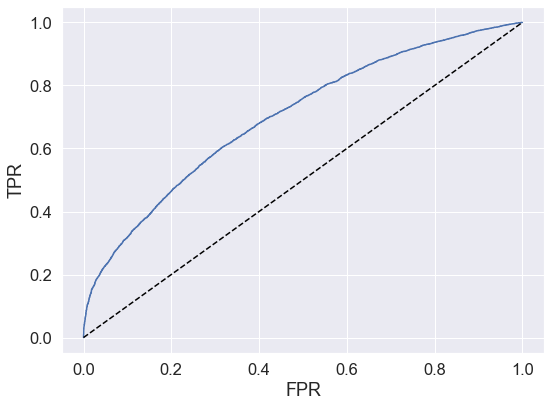

In [11]:
# plot ROC_AUC
import matplotlib.pyplot as plt 
import matplotlib as mpl 
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(font_scale=1.5)

from sklearn import metrics

y_pred_proba_test = opt_xgb_clf.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.tight_layout()

Text(0.5, 1.0, 'Confusion matrix')

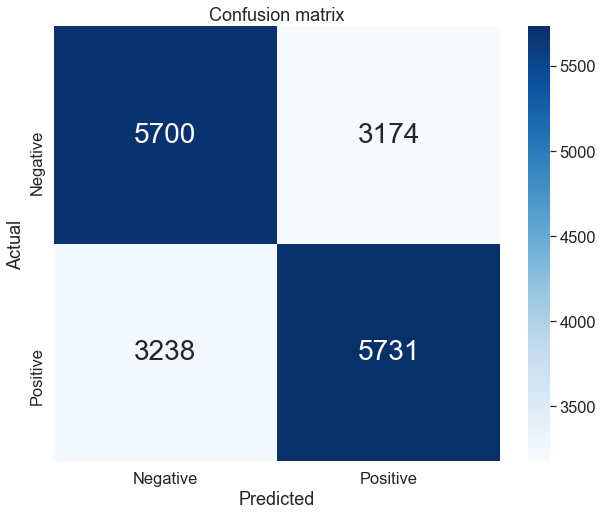

In [12]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_test)

lables = {'Negative': 0, 'Positive': 1} 

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True,
            annot_kws={'size':28},
            fmt="d",
            xticklabels=lables.keys(), 
            yticklabels=lables.keys(),
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

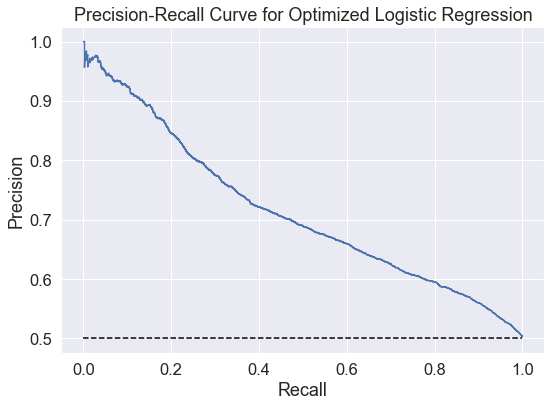

In [13]:
# plot precision - recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.plot([0, 1], [0.5, 0.5], '--', color = 'black')
plt.title('Precision-Recall Curve for Optimized Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()

In [14]:
search.best_params_

{'preprocessor__num__strategy': 'mean',
 'preprocessor__cat_num__strategy': 'constant',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'constant',
 'classifier__subsample': 0.6,
 'classifier__reg_lambda': 1,
 'classifier__reg_alpha': 0,
 'classifier__n_estimators': 500,
 'classifier__min_child_weight': 7,
 'classifier__max_depth': 6,
 'classifier__learning_rate': 0.05,
 'classifier__gamma': 0.01,
 'classifier__colsample_bytree': 0.3}

In [15]:
# Preprocessing for numerical data
numerical_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__num__strategy'])

# Preprocessing for binary data
binary_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__bin__strategy'])

# Preprocessing for categorical data encoded as numerical ID's
categorical_num_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__cat_num__strategy'])

# Preprocessing for categorical data
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search.best_params_['preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, numerical_columns),
        ('bin', binary_transformer_rev, binary_columns),
        ('cat_num', categorical_num_transformer_rev, cat_num_columns),
        ('cat', categorical_transformer_rev, categorical_columns)
    ])

# Bundle preprocessing and modeling code in a pipeline
pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev),
                              ('VarThresh', VarThresh)
                             ])

In [16]:
X_values = preprocessor_rev.fit_transform(X_train)
onehot_cat_columns = pipeline_rev.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_columns)
onehot = onehot_cat_columns.tolist() 
columns_tot = numerical_columns + binary_columns + cat_num_columns + onehot

feature_importance = pd.Series(data=opt_xgb_clf.named_steps['classifier'].feature_importances_, index = np.array(columns_tot))

In [17]:
feature_importance = feature_importance.sort_values(ascending=False)

<AxesSubplot:>

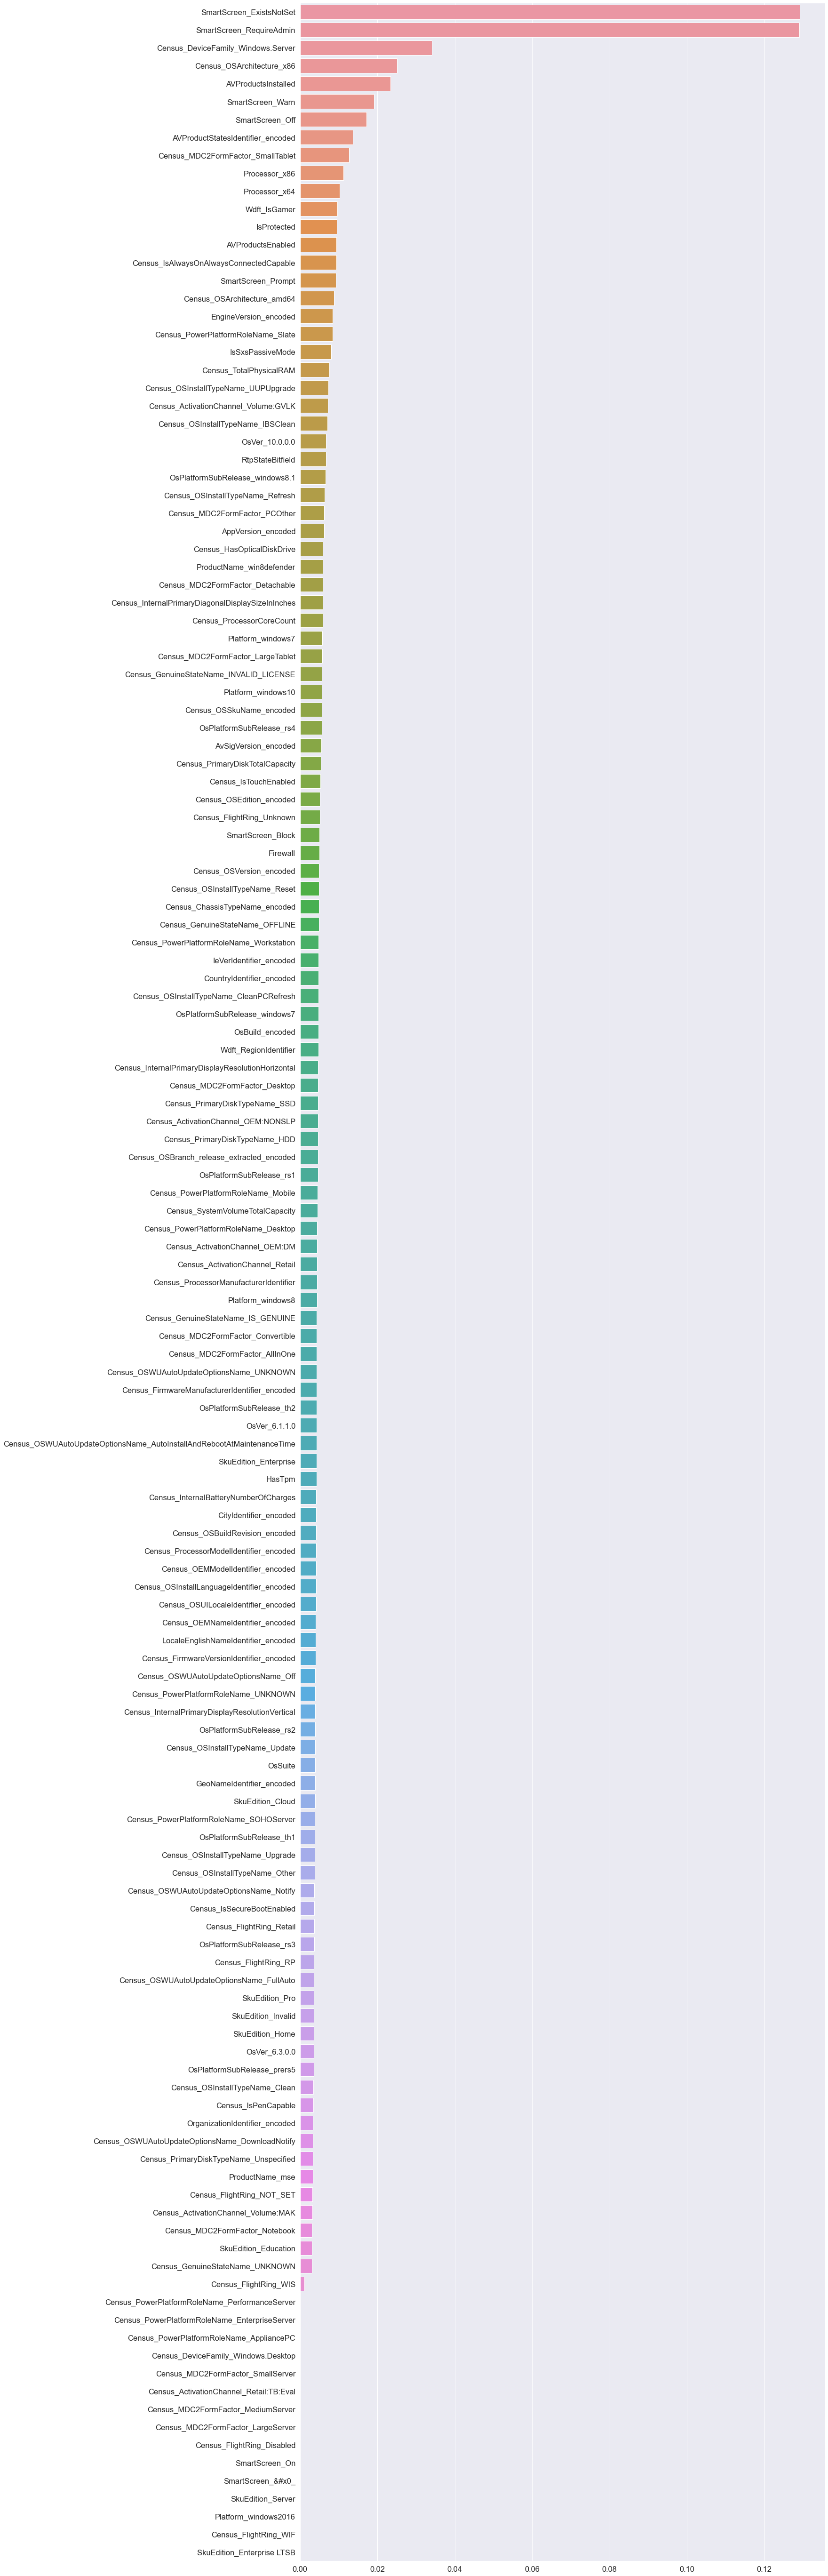

In [18]:
plt.figure(figsize=(20,100))
sns.barplot(y=feature_importance.index, 
            x=feature_importance.values, 
            orient='h')

In [19]:
from sklearn.model_selection import learning_curve

opt_xgb_clf_rev = opt_xgb_clf
train_sizes, train_scores, test_scores = learning_curve(opt_xgb_clf_rev, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=5, 
                                                        scoring='roc_auc',
                                                        n_jobs=1,
                                                        train_sizes=np.linspace(.01, 1.0, 5), 
                                                        verbose=3)

[learning_curve] Training set sizes: [  570 14702 28833 42964 57096]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................., score=(train=0.998, test=0.605) total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ..................., score=(train=0.906, test=0.681) total time=   5.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV] END ..................., score=(train=0.850, test=0.692) total time=  10.0s
[CV] END ..................., score=(train=0.819, test=0.699) total time=  14.7s
[CV] END ..................., score=(train=0.800, test=0.701) total time=  19.5s
[CV] END ..................., score=(train=0.997, test=0.620) total time=   0.6s
[CV] END ..................., score=(train=0.903, test=0.682) total time=   5.3s
[CV] END ..................., score=(train=0.847, test=0.693) total time=   9.9s
[CV] END ..................., score=(train=0.818, test=0.697) total time=  15.2s
[CV] END ..................., score=(train=0.799, test=0.701) total time=  19.7s
[CV] END ..................., score=(train=0.997, test=0.608) total time=   0.6s
[CV] END ..................., score=(train=0.903, test=0.677) total time=   5.4s
[CV] END ..................., score=(train=0.846, test=0.688) total time=  10.1s
[CV] END ..................., score=(train=0.821, test=0.696) total time=  14.8s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  4.4min finished


Text(0.5, 1.0, 'Learning Curve (XGB)')

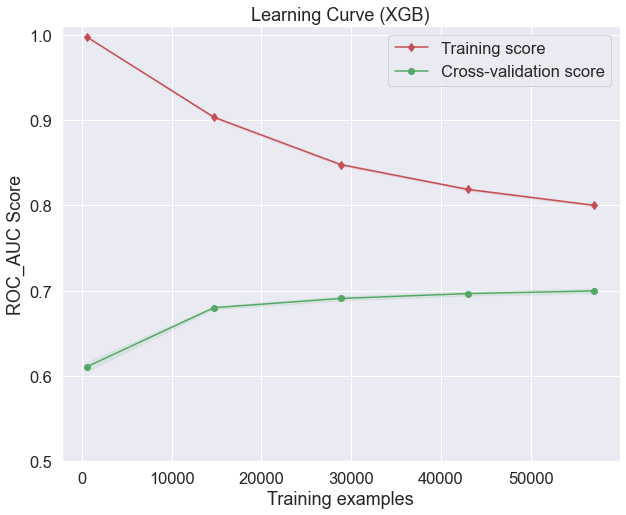

In [20]:
# Plot learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'd-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
plt.ylim(0.5, 1.01)
   
    
plt.legend(loc='best')
plt.xlabel('Training examples')
plt.ylabel('ROC_AUC Score')
plt.title('Learning Curve (XGB)')

In [21]:
X_train_full = [X_train, X_test]
y_train_full= [y_train, y_test]

X_train_full = pd.concat(X_train_full)
y_train_full = pd.concat(y_train_full)

X_train_full.shape, y_train_full.shape

((89214, 65), (89214,))

In [22]:
opt_xgb_clf.fit(X_train_full, y_train_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Census_ProcessorCoreCount',
                                                   'Census_PrimaryDiskTotalCapacity',
                                                   'Census_SystemVolumeTotalCapacity',
                                                   'Census_TotalPhysicalRAM',
                                                   'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                   'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                   'Census_InternalPrimaryDisplayResol...
                               gamma=0.01, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=6,
                               min_child_weig

In [24]:
with open("../data/processed/optimized_XGB.pickle", "wb") as handle:
    pickle.dump(opt_xgb_clf, handle)